# <a id='toc1_'></a>[Simulation-based Inference with ACE](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Simulation-based Inference with ACE](#toc1_)    
  - [Notebook description](#toc1_1_)    
  - [Imports](#toc1_2_)    
  - [Load trained ACE model](#toc1_3_)    
  - [Generate parameter-simulation pairs](#toc1_4_)    
  - [Visualize simulations](#toc1_5_)    
  - [Latents prediction](#toc1_6_)    
    - [Calculate log-prob and RMSE for ACE](#toc1_6_1_)    
    - [Train NPE](#toc1_6_2_)    
    - [Calculate log-prob and RMSE for NPE](#toc1_6_3_)    
    - [Visualize posterior](#toc1_6_4_)    
  - [Data prediction](#toc1_7_)    
    - [Generate datasets](#toc1_7_1_)    
    - [Generate samples by ACE](#toc1_7_2_)    
    - [Visualize data prediction performance](#toc1_7_3_)    
  - [Simulation-based calibration](#toc1_8_)    
    - [Check SBC for ACE on pre-defined global prior](#toc1_8_1_)    
  - [Check SBC of ACE and ACEP on custom prior](#toc1_9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Notebook description](#toc0_)
This notebook demonstrates how Amortized Conditioning Engine (ACE) can be applied to Simulation-based inference (SBI), using Turin model as an illustrative example. We first present the performance of ACE in latent prediction, comparing ACE and ACEP with NPE. ACEP is a variant of ACE where we provide the model with informative priors over the parameters at runtime, allowing it to incorporate prior knowledge into the posterior estimation. Then, we demonstrate ACE's ability to predict missing data, and finally, we carry out a simulation-based calibration check.

## <a id='toc1_2_'></a>[Imports](#toc0_)

In [ ]:
import hydra
import matplotlib.pyplot as plt
import matplotlib
import torch
from hydra import initialize, compose
from src.model.base import BaseTransformer
from src.dataset.sampler_joint import Sampler
from src.dataset.sampler_twoway import Sampler as Sampler_base
from src.dataset.sbi.turin import (
    Turin,
    TurinOnlineAll,
    TurinOnlineAllSamePrior,
    TurinOnline,
)
import os
import seaborn as sns
import sbi
from sbi.inference.snpe.snpe_c import SNPE_C
from sbi.utils.torchutils import *
from sbi.utils import process_prior
from sbi.utils.user_input_checks import *
from scipy.interpolate import make_interp_spline, BSpline
from scipy import stats
from sbi_demo_utils import *
import warnings

warnings.filterwarnings("ignore")

update_plot_style()

## <a id='toc1_3_'></a>[Load trained ACE model](#toc0_)

In [ ]:
cfg_twoway, model_twoway = load_config_and_model(
    path="model/turin/"
)  # Load trained ACE
cfg_twoway_pi, model_twoway_pi = load_config_and_model(
    path="model/turin_pi/"
)  # Load trained ACE with customized prior

## <a id='toc1_4_'></a>[Generate parameter-simulation pairs](#toc0_)

In [ ]:
batch_size = 100
dataset = TurinOnlineAll(order="fixed")

sampler_joint = Sampler(
    problem=dataset,
    batch_size=batch_size,
    num_latent=4,
    min_num_points=50,
    max_num_points=51 + 1,
)

_, eval_set_twoway, eval_set_pi_twoway_narrow, eval_set_pi_twoway_wide = (
    sampler_joint.sample_all_bin()
)

## <a id='toc1_5_'></a>[Visualize simulations](#toc0_)

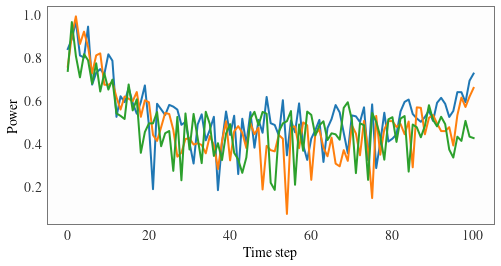

In [ ]:
plt.figure(figsize=(8, 4))
for i in range(3):
    plt.plot(eval_set_twoway.xc[i, :, 1], eval_set_twoway.yc[i, :])
plt.xlabel("Time step")
plt.ylabel("Power")
plt.show()

## <a id='toc1_6_'></a>[Latents prediction](#toc0_)

### <a id='toc1_6_1_'></a>[Calculate log-prob and RMSE for ACE](#toc0_)

In [ ]:
out_twoway = model_twoway.forward(eval_set_twoway, predict=True)
samples_twoway = out_twoway.samples
log_probs_twoway = out_twoway.losses.sum(dim=-1)
all_log_probs_ace_twoway = log_probs_twoway.mean().detach().numpy()
all_rmse_ace_twoway = RMSE(eval_set_twoway.yt, samples_twoway)

out_twoway_pi_narrow = model_twoway_pi.forward(eval_set_pi_twoway_narrow, predict=True)
samples_twoway_pi_narrow = out_twoway_pi_narrow.samples
log_probs_twoway_pi_narrow = out_twoway_pi_narrow.losses.sum(dim=-1)
all_log_probs_ace_pi_narrow = log_probs_twoway_pi_narrow.mean().detach().numpy()
all_rmse_ace_pi_narrow = RMSE(eval_set_twoway.yt, samples_twoway_pi_narrow)

out_twoway_pi_wide = model_twoway_pi.forward(eval_set_pi_twoway_wide, predict=True)
samples_twoway_pi_wide = out_twoway_pi_wide.samples
log_probs_twoway_pi_wide = out_twoway_pi_wide.losses.sum(dim=-1)
all_log_probs_ace_pi_wide = log_probs_twoway_pi_wide.mean().detach().numpy()
all_rmse_ace_pi_wide = RMSE(eval_set_twoway.yt, samples_twoway_pi_wide)

print(f"ACE Log probs: {all_log_probs_ace_twoway.item():.2f}")
print(f"ACE RMSE: {all_rmse_ace_twoway.item():.2f}")

print(f"ACEP with weak prior Log probs: {all_log_probs_ace_pi_wide.item():.2f}")
print(f"ACEP with weak prior RMSE: {all_rmse_ace_pi_wide.item():.2f}")

print(f"ACEP with strong prior Log probs: {all_log_probs_ace_pi_narrow.item():.2f}")
print(f"ACEP with strong prior RMSE: {all_rmse_ace_pi_narrow.item():.2f}")

ACE Log probs: 2.99
ACE RMSE: 0.25
ACEP with weak prior Log probs: 5.90
ACEP with weak prior RMSE: 0.10
ACEP with strong prior Log probs: 7.05
ACEP with strong prior RMSE: 0.08


### <a id='toc1_6_2_'></a>[Train NPE](#toc0_)

We are now training an NPE model using the same data that was used to train ACE.

In [ ]:
x_npe = torch.load(".data/x_turin_10000.pt")
theta_npe = torch.load(".data/theta_turin_10000.pt")

# We already normalized the parameters when saved the data
prior = [
    Uniform(torch.tensor([0.0]), torch.tensor([1.0])),
    Uniform(torch.tensor([0.0]), torch.tensor([1.0])),
    Uniform(torch.tensor([0.0]), torch.tensor([1.0])),
    Uniform(torch.tensor([0.0]), torch.tensor([1.0])),
]

prior, *_ = process_prior(prior)

posterior_npe = train_npe(prior, theta_npe, x_npe)

### <a id='toc1_6_3_'></a>[Calculate log-prob and RMSE for NPE](#toc0_)

In [ ]:
log_probs_npe = torch.zeros([batch_size])
for i in range(batch_size):
    log_probs_npe[i] = posterior_npe.log_prob(
        theta=eval_set_twoway.yt[i].reshape(-1, 4),
        x=eval_set_twoway.yc[i].reshape(-1, 101),
    )
all_log_probs_npe = log_probs_npe.mean().numpy()

samples_npe_all = torch.empty([batch_size, 4, 100])
for i in range(batch_size):
    samples_npe_all[i] = posterior_npe.sample(
        (100,), x=eval_set_twoway.yc[i].reshape(-1, 101), show_progress_bars=False
    ).T
all_rmse_npe = RMSE(eval_set_twoway.yt, samples_npe_all)

print(f"NPE Log probs mean: {all_log_probs_npe.item():.2f}")
print(f"NPE RMSE mean: {all_rmse_npe.item():.2f}")

NPE Log probs mean: 2.14
NPE RMSE mean: 0.27


### <a id='toc1_6_4_'></a>[Visualize posterior](#toc0_)

We visualize the posterior distribution of the parameters obtained by ACE, ACEP with strong prior and NPE.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

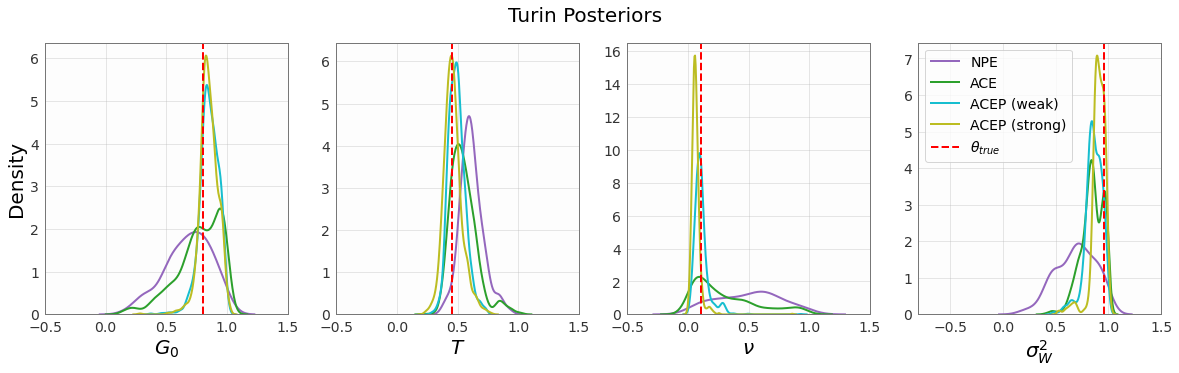

In [ ]:
seed = 5

npe_samples = posterior_npe.sample((100,), x=eval_set_twoway.yc[seed].reshape(-1, 101))

plt.figure(figsize=[20, 5])
plt.suptitle(f"Turin Posteriors", size=20)

plt.subplot(1, 4, 1)
sns.kdeplot(npe_samples[:, 0], color="C4", linewidth=2, linestyle="solid", label="NPE")
sns.kdeplot(
    samples_twoway[seed, 0, :], color="C2", linewidth=2, linestyle="solid", label="ACE"
)
sns.kdeplot(
    samples_twoway_pi_wide[seed, 0, :],
    color="C9",
    linewidth=2,
    linestyle="solid",
    label="ACEP (weak)",
)
sns.kdeplot(
    samples_twoway_pi_narrow[seed, 0, :],
    color="C8",
    linewidth=2,
    linestyle="solid",
    label="ACEP (strong)",
)
plt.axvline(
    x=eval_set_twoway.yt[seed, 0].detach().numpy(),
    color="r",
    linestyle="--",
    linewidth=2,
    label="$\\theta_{true}$",
)
plt.xlim(-0.5, 1.5)
plt.xlabel("$G_0$", fontsize=20)
plt.ylabel("Density", fontsize=20)

plt.grid()

plt.subplot(1, 4, 2)
sns.kdeplot(npe_samples[:, 1], color="C4", linewidth=2, linestyle="solid", label="NPE")
sns.kdeplot(
    samples_twoway[seed, 1, :], color="C2", linewidth=2, linestyle="solid", label="ACE"
)
sns.kdeplot(
    samples_twoway_pi_wide[seed, 1, :],
    color="C9",
    linewidth=2,
    linestyle="solid",
    label="ACEP (weak)",
)
sns.kdeplot(
    samples_twoway_pi_narrow[seed, 1, :],
    color="C8",
    linewidth=2,
    linestyle="solid",
    label="ACEP (strong)",
)
plt.axvline(
    x=eval_set_twoway.yt[seed, 1].detach().numpy(),
    color="r",
    linestyle="--",
    linewidth=2,
    label="$\\theta_{true}$",
)
plt.xlim(-0.5, 1.5)
plt.xlabel("$T$", fontsize=20)
plt.ylabel(None)
plt.grid()

plt.subplot(1, 4, 3)
sns.kdeplot(npe_samples[:, 2], color="C4", linewidth=2, linestyle="solid", label="NPE")
sns.kdeplot(
    samples_twoway[seed, 2, :], color="C2", linewidth=2, linestyle="solid", label="ACE"
)
sns.kdeplot(
    samples_twoway_pi_wide[seed, 2, :],
    color="C9",
    linewidth=2,
    linestyle="solid",
    label="ACEP (weak)",
)
sns.kdeplot(
    samples_twoway_pi_narrow[seed, 2, :],
    color="C8",
    linewidth=2,
    linestyle="solid",
    label="ACEP (strong)",
)
plt.axvline(
    x=eval_set_twoway.yt[seed, 2].detach().numpy(),
    color="r",
    linestyle="--",
    linewidth=2,
    label="$\\theta_{true}$",
)
plt.xlim(-0.5, 1.5)
plt.xlabel("$\\nu$", fontsize=20)
plt.ylabel(None)
plt.grid()

plt.subplot(1, 4, 4)
sns.kdeplot(npe_samples[:, 3], color="C4", linewidth=2, linestyle="solid", label="NPE")
sns.kdeplot(
    samples_twoway[seed, 3, :], color="C2", linewidth=2, linestyle="solid", label="ACE"
)
sns.kdeplot(
    samples_twoway_pi_wide[seed, 3, :],
    color="C9",
    linewidth=2,
    linestyle="solid",
    label="ACEP (weak)",
)
sns.kdeplot(
    samples_twoway_pi_narrow[seed, 3, :],
    color="C8",
    linewidth=2,
    linestyle="solid",
    label="ACEP (strong)",
)
plt.axvline(
    x=eval_set_twoway.yt[seed, 3].detach().numpy(),
    color="r",
    linestyle="--",
    linewidth=2,
    label="$\\theta_{true}$",
)
plt.xlim(-0.8, 1.5)
plt.xlabel("$\sigma^2_W$", fontsize=20)
plt.ylabel(None)
plt.grid()
plt.legend(fontsize=14, loc=2)
plt.show()

## <a id='toc1_7_'></a>[Data prediction](#toc0_)

ACE can predict missing data given partial observations. We randomly designate half of the data points as missing and use the remaining half as context for predictions.

### <a id='toc1_7_1_'></a>[Generate datasets](#toc0_)

In [ ]:
eval_set_ppd, _, _ = sampler_joint.sample_ppd(sampling_way=3, know_theta=False)

### <a id='toc1_7_2_'></a>[Generate samples by ACE](#toc0_)

In [ ]:
out_ppd_twoway = model_twoway.forward(eval_set_ppd, predict=True)
samples_ppd_twoway = out_ppd_twoway.samples

### <a id='toc1_7_3_'></a>[Visualize data prediction performance](#toc0_)

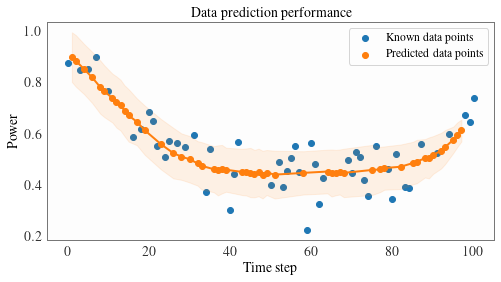

In [ ]:
seed = 1

# Extract and sort x-values
x_values = eval_set_ppd.xt[seed, :, 1].reshape(-1)
sorted_indices = np.argsort(x_values)

# Sort x-values, predicted mean, and standard deviation
sorted_x_values = x_values[sorted_indices]
predicted_mean = samples_ppd_twoway[seed].mean(-1).reshape(-1)[sorted_indices]
predicted_std = samples_ppd_twoway[seed].std(-1).reshape(-1)[sorted_indices]

# Plot
plt.figure(figsize=(8, 4))
plt.scatter(
    eval_set_ppd.xc[seed, :, 1].reshape(-1),
    eval_set_ppd.yc[seed].reshape(-1),
    label="Known data points",
)
plt.scatter(sorted_x_values, predicted_mean, label="Predicted data points", color="C1")
plt.plot(sorted_x_values, predicted_mean, color="C1")
plt.fill_between(
    sorted_x_values,
    predicted_mean - predicted_std,
    predicted_mean + predicted_std,
    color="C1",
    alpha=0.1,
)
plt.legend()
plt.title("Data prediction performance")
plt.xlabel("Time step")
plt.ylabel("Power")
plt.show()

## <a id='toc1_8_'></a>[Simulation-based calibration](#toc0_)

Here we perform simulation-based calibration (SBC) for Turin, see appendix C.4.3 of the paper for detailed description.

In [ ]:
batch_size = 1000
dataset = TurinOnline(order="fixed")

num_ctx_for_ppd = 50

# define sampler
sampler_base = Sampler_base(
    problem=dataset,
    num_ctx=101,
    batch_size=batch_size,
    num_latent=4,
    min_num_points=num_ctx_for_ppd,
    max_num_points=num_ctx_for_ppd + 1,
    ctx_tar_sampler="predict_latents_fixed",
)

eval_set = sampler_base.sample()

out_twoway = model_twoway.forward(eval_set, predict=True, num_samples=100)
ace_posterior_samples = out_twoway.samples
prior_samples = eval_set.yt.squeeze(-1)

### <a id='toc1_8_1_'></a>[Check SBC for ACE on pre-defined global prior](#toc0_)

The following figure shows that our ACE is well-calibrated with pre-defined uniform priors across all four latents.

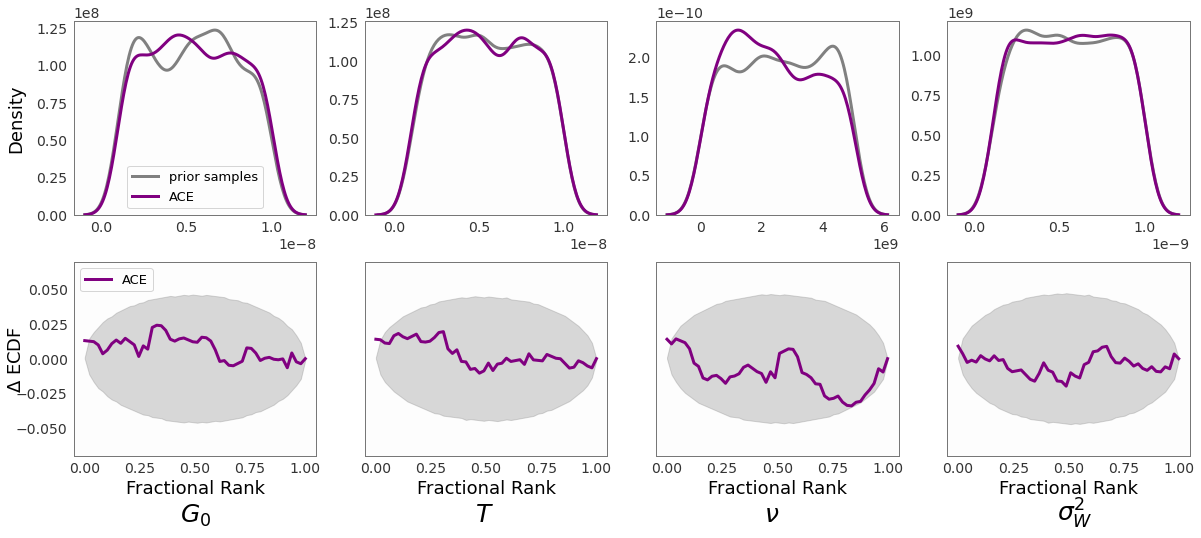

In [ ]:
# Unnormalize parameters
ace_posterior_samples_1 = ace_posterior_samples[:, 0, 1] * (1e-8 - 1e-9) + 1e-9
prior_samples_1 = prior_samples[:, 0] * (1e-8 - 1e-9) + 1e-9
ace_posterior_samples_2 = ace_posterior_samples[:, 1, 1] * (1e-8 - 1e-9) + 1e-9
prior_samples_2 = prior_samples[:, 1] * (1e-8 - 1e-9) + 1e-9
ace_posterior_samples_3 = ace_posterior_samples[:, 2, 1] * (5e9 - 1e7) + 1e7
prior_samples_3 = prior_samples[:, 2] * (5e9 - 1e7) + 1e7
ace_posterior_samples_4 = ace_posterior_samples[:, 3, 1] * (1e-9 - 1e-10) + 1e-10
prior_samples_4 = prior_samples[:, 3] * (1e-9 - 1e-10) + 1e-10

fig, axs = plt.subplots(2, 4, figsize=(20, 8))

sns.kdeplot(
    prior_samples_1,
    color="grey",
    linewidth=3,
    linestyle="solid",
    label="prior samples",
    ax=axs[0, 0],
)
sns.kdeplot(
    ace_posterior_samples_1,
    color="purple",
    linewidth=3,
    linestyle="solid",
    label="ACE",
    ax=axs[0, 0],
)
axs[0, 0].set_ylabel("Density", fontsize=18)
# axs[0, 0].set_xlabel("$x$", fontsize=18)
axs[0, 0].legend(fontsize=13, loc=8)
axs[0, 0].yaxis.set_label_coords(-0.2, 0.5)

sns.kdeplot(
    prior_samples_2,
    color="grey",
    linewidth=3,
    linestyle="solid",
    label="prior",
    ax=axs[0, 1],
)
sns.kdeplot(
    ace_posterior_samples_2,
    color="purple",
    linewidth=3,
    linestyle="solid",
    label="ACE",
    ax=axs[0, 1],
)
axs[0, 1].set_ylabel("")

sns.kdeplot(
    prior_samples_3,
    color="grey",
    linewidth=3,
    linestyle="solid",
    label="prior",
    ax=axs[0, 2],
)
sns.kdeplot(
    ace_posterior_samples_3,
    color="purple",
    linewidth=3,
    linestyle="solid",
    label="ACE",
    ax=axs[0, 2],
)
axs[0, 2].set_ylabel("")

sns.kdeplot(
    prior_samples_4,
    color="grey",
    linewidth=3,
    linestyle="solid",
    label="prior",
    ax=axs[0, 3],
)
sns.kdeplot(
    ace_posterior_samples_4,
    color="purple",
    linewidth=3,
    linestyle="solid",
    label="ACE",
    ax=axs[0, 3],
)
axs[0, 3].set_ylabel("")

plot_sbc_ecdf_diff_no_pi(
    axs[1, 0],
    prior_samples[:, 0].unsqueeze(-1),
    ace_posterior_samples[:, 0, :],
    num_points=50,
)
axs[1, 0].set_ylabel(r"$\Delta$ ECDF", fontsize=18)
axs[1, 0].yaxis.set_label_coords(-0.2, 0.5)
axs[1, 0].legend(fontsize=13, loc=2)

plot_sbc_ecdf_diff_no_pi(
    axs[1, 1],
    prior_samples[:, 1].unsqueeze(-1),
    ace_posterior_samples[:, 1, :],
    num_points=50,
)
axs[1, 1].set_yticks([])
plot_sbc_ecdf_diff_no_pi(
    axs[1, 2],
    prior_samples[:, 2].unsqueeze(-1),
    ace_posterior_samples[:, 2, :],
    num_points=50,
)
axs[1, 2].set_yticks([])
plot_sbc_ecdf_diff_no_pi(
    axs[1, 3],
    prior_samples[:, 3].unsqueeze(-1),
    ace_posterior_samples[:, 3, :],
    num_points=50,
)
axs[1, 3].set_yticks([])

fig.text(0.21, 0.01, "$G_0$", ha="center", fontsize=25)
fig.text(0.41, 0.01, "$T$", ha="center", fontsize=25)
fig.text(0.61, 0.01, "$\\nu$", ha="center", fontsize=25)
fig.text(0.82, 0.011, "$\sigma^2_W$", ha="center", fontsize=25)

plt.subplots_adjust(hspace=0.24)
plt.show()

## <a id='toc1_9_'></a>[Check SBC of ACE and ACEP on custom prior](#toc0_)

Since ACEP allows conditioning on different priors at runtime, we also test the calibration of ACEP using randomly generated priors.

In [702]:
batch_size = 500
dataset = TurinOnlineAllSamePrior(order="fixed")

num_ctx_for_ppd = 50

# define sampler
sampler_joint = Sampler(
    problem=dataset,
    batch_size=batch_size,
    num_latent=4,
    min_num_points=num_ctx_for_ppd,
    max_num_points=num_ctx_for_ppd + 1,
)

_, eval_set_twoway, eval_set_pi_twoway, _ = sampler_joint.sample_all_bin()

In [572]:
out_twoway = model_twoway.forward(eval_set_twoway, predict=True, num_samples=100)
ace_posterior_samples = out_twoway.samples
prior_samples = eval_set_twoway.yt.squeeze(-1)

out_twoway_pi = model_twoway_pi.forward(
    eval_set_pi_twoway, predict=True, num_samples=100
)
ace_posterior_samples_pi = out_twoway_pi.samples

In [653]:
torch.save(prior_samples, ".data/sbc_prior_samples.pt")
torch.save(ace_posterior_samples, ".data/sbc_posterior_samples.pt")
torch.save(ace_posterior_samples_pi, ".data/sbc_posterior_samples_pi.pt")

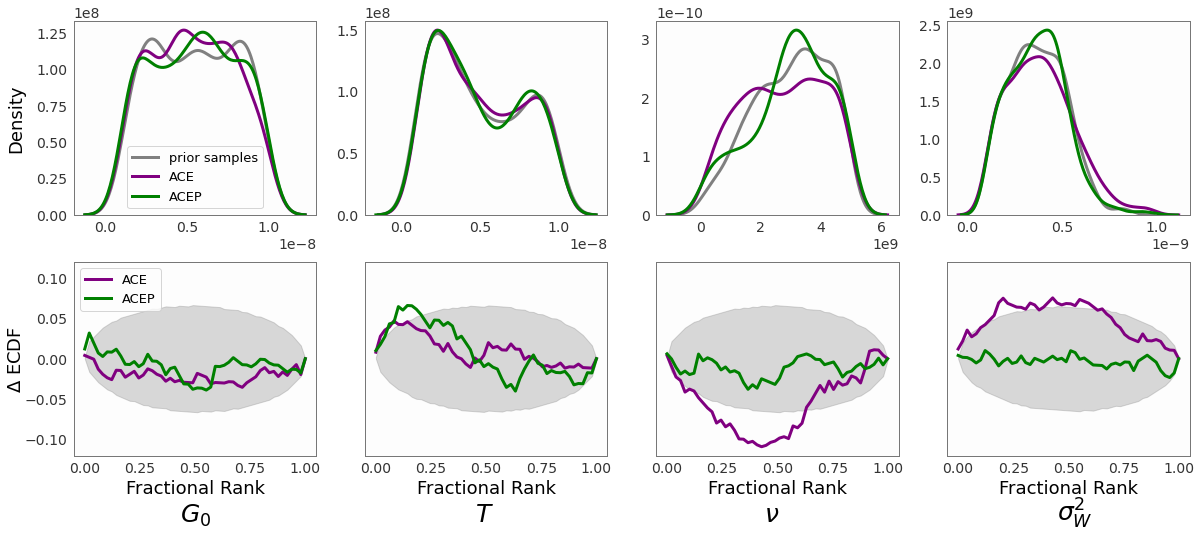

In [743]:
prior_samples = torch.load(".data/sbc_prior_samples.pt")
ace_posterior_samples = torch.load(".data/sbc_posterior_samples.pt")
ace_posterior_samples_pi = torch.load(".data/sbc_posterior_samples_pi.pt")

# Unnormalize
ace_posterior_samples_1 = ace_posterior_samples[:, 0, 1] * (1e-8 - 1e-9) + 1e-9
ace_posterior_samples_pi_1 = ace_posterior_samples_pi[:, 0, 1] * (1e-8 - 1e-9) + 1e-9
prior_samples_1 = prior_samples[:, 0] * (1e-8 - 1e-9) + 1e-9
ace_posterior_samples_2 = ace_posterior_samples[:, 1, 1] * (1e-8 - 1e-9) + 1e-9
ace_posterior_samples_pi_2 = ace_posterior_samples_pi[:, 1, 1] * (1e-8 - 1e-9) + 1e-9
prior_samples_2 = prior_samples[:, 1] * (1e-8 - 1e-9) + 1e-9
ace_posterior_samples_3 = ace_posterior_samples[:, 2, 1] * (5e9 - 1e7) + 1e7
ace_posterior_samples_pi_3 = ace_posterior_samples_pi[:, 2, 1] * (5e9 - 1e7) + 1e7
prior_samples_3 = prior_samples[:, 2] * (5e9 - 1e7) + 1e7
ace_posterior_samples_4 = ace_posterior_samples[:, 3, 1] * (1e-9 - 1e-10) + 1e-10
ace_posterior_samples_pi_4 = ace_posterior_samples_pi[:, 3, 1] * (1e-9 - 1e-10) + 1e-10
prior_samples_4 = prior_samples[:, 3] * (1e-9 - 1e-10) + 1e-10

fig, axs = plt.subplots(2, 4, figsize=(20, 8))

sns.kdeplot(
    prior_samples_1,
    color="grey",
    linewidth=3,
    linestyle="solid",
    label="prior samples",
    ax=axs[0, 0],
)
sns.kdeplot(
    ace_posterior_samples_1,
    color="purple",
    linewidth=3,
    linestyle="solid",
    label="ACE",
    ax=axs[0, 0],
)
sns.kdeplot(
    ace_posterior_samples_pi_1,
    color="green",
    linewidth=3,
    linestyle="solid",
    label="ACEP",
    ax=axs[0, 0],
)
axs[0, 0].set_ylabel("Density", fontsize=18)
axs[0, 0].legend(fontsize=13, loc=8)
axs[0, 0].yaxis.set_label_coords(-0.2, 0.5)

sns.kdeplot(
    prior_samples_2,
    color="grey",
    linewidth=3,
    linestyle="solid",
    label="prior",
    ax=axs[0, 1],
)
sns.kdeplot(
    ace_posterior_samples_2,
    color="purple",
    linewidth=3,
    linestyle="solid",
    label="ACE",
    ax=axs[0, 1],
)
sns.kdeplot(
    ace_posterior_samples_pi_2,
    color="green",
    linewidth=3,
    linestyle="solid",
    label="ACEP",
    ax=axs[0, 1],
)
axs[0, 1].set_ylabel("")

sns.kdeplot(
    prior_samples_3,
    color="grey",
    linewidth=3,
    linestyle="solid",
    label="prior",
    ax=axs[0, 2],
)
sns.kdeplot(
    ace_posterior_samples_3,
    color="purple",
    linewidth=3,
    linestyle="solid",
    label="ACE",
    ax=axs[0, 2],
)
sns.kdeplot(
    ace_posterior_samples_pi_3,
    color="green",
    linewidth=3,
    linestyle="solid",
    label="ACEP",
    ax=axs[0, 2],
)
# axs[0, 2].set_xlim(-0.2, 1.2)
axs[0, 2].set_ylabel("")

sns.kdeplot(
    prior_samples_4,
    color="grey",
    linewidth=3,
    linestyle="solid",
    label="prior",
    ax=axs[0, 3],
)
sns.kdeplot(
    ace_posterior_samples_4,
    color="purple",
    linewidth=3,
    linestyle="solid",
    label="ACE",
    ax=axs[0, 3],
)
sns.kdeplot(
    ace_posterior_samples_pi_4,
    color="green",
    linewidth=3,
    linestyle="solid",
    label="ACEP",
    ax=axs[0, 3],
)
axs[0, 3].set_ylabel("")

plot_sbc_ecdf_diff(
    axs[1, 0],
    prior_samples[:, 0].unsqueeze(-1),
    ace_posterior_samples[:, 0, :],
    ace_posterior_samples_pi[:, 0, :],
    num_points=50,
)
axs[1, 0].set_ylabel(r"$\Delta$ ECDF", fontsize=18)
axs[1, 0].yaxis.set_label_coords(-0.2, 0.5)
axs[1, 0].legend(fontsize=13, loc=2)

plot_sbc_ecdf_diff(
    axs[1, 1],
    prior_samples[:, 1].unsqueeze(-1),
    ace_posterior_samples[:, 1, :],
    ace_posterior_samples_pi[:, 1, :],
    num_points=50,
)
axs[1, 1].set_yticks([])
plot_sbc_ecdf_diff(
    axs[1, 2],
    prior_samples[:, 2].unsqueeze(-1),
    ace_posterior_samples[:, 2, :],
    ace_posterior_samples_pi[:, 2, :],
    num_points=50,
)
axs[1, 2].set_yticks([])
plot_sbc_ecdf_diff(
    axs[1, 3],
    prior_samples[:, 3].unsqueeze(-1),
    ace_posterior_samples[:, 3, :],
    ace_posterior_samples_pi[:, 3, :],
    num_points=50,
)
axs[1, 3].set_yticks([])

fig.text(0.21, 0.01, "$G_0$", ha="center", fontsize=25)
fig.text(0.41, 0.01, "$T$", ha="center", fontsize=25)
fig.text(0.61, 0.01, "$\\nu$", ha="center", fontsize=25)
fig.text(0.82, 0.011, "$\sigma^2_W$", ha="center", fontsize=25)

plt.subplots_adjust(hspace=0.24)
plt.show()